## Naive Bayes
Sarah Go

## Import Libraries and Dataset

In [19]:
import kagglehub

import pickle

import string
import re
import numpy as np
import pandas as pd

from tabulate import tabulate
import matplotlib.pyplot as plt

from wordcloud import WordCloud
import seaborn as sns
from textblob import TextBlob

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import joblib

# Ensure NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\radadmin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\radadmin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
# Download latest version
path = kagglehub.dataset_download("saurabhshahane/fake-news-classification")

print("Path to dataset files:", path)

# load datasets
df=pd.read_csv(path+'/WELFake_Dataset.csv')

df['article'] = df['title'] + df['text']
df = df[['article', 'label']]
df.head()

Path to dataset files: C:\Users\radadmin\.cache\kagglehub\datasets\saurabhshahane\fake-news-classification\versions\77


,article,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,1
1,NaN,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",0
4,SATAN 2: Russia unvelis an image of its terrif...,1


## Preprocessing

In [5]:
print("Size before dropping duplicates and missing data: ",df.shape)
df.dropna(inplace=True)
df.drop_duplicates(subset='article', inplace=True)
print("Size after dropping duplicates and missing data: ",df.shape)

Size before dropping duplicates and missing data:  (72134, 2)
Size after dropping duplicates and missing data:  (63121, 2)


In [11]:
df['sentiment_polarity'] = df['article'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
df['sentiment_subjectivity'] = df['article'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)
df.head()

,article,label,sentiment_polarity,sentiment_subjectivity
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,1,0.034641,0.296824
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,1,0.190402,0.512798
3,"Bobby Jindal, raised Hindu, uses story of Chri...",0,0.111493,0.387106
4,SATAN 2: Russia unvelis an image of its terrif...,1,0.013342,0.403577
5,About Time! Christian Group Sues Amazon and SP...,1,-0.100461,0.428571


In [12]:
X_train, X_test, y_train, y_test = train_test_split(df['article'], df['label'], test_size=0.2, random_state=42, stratify=df['label'])
overlap = set(X_train).intersection(set(X_test))
print(f"Number of overlapping samples between train and test sets: {len(overlap)}")

Number of overlapping samples between train and test sets: 0


In [ ]:
# Save data
with open('saved_models_and_data/preprocessed_data.pkl', 'wb') as file:
    pickle.dump((X_train, X_test, y_train, y_test), file)
print("Data saved.")

Data saved.


In [13]:
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    text = re.sub(r'\b([a-zA-Z])\.(?=[a-zA-Z])', r'\1specialdot', text)  # Preserve acronyms
    text = re.sub(r'\b([a-zA-Z])\.(?=\s|$)', r'\1specialdot', text)
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = text.replace("specialdot", ".")
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize, remove stopwords, and lemmatize
    tokens = text.split()
    stop_words = set(stopwords.words('english'))
    stop_words.discard("not")
    stop_words.discard("no")
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Vectorize text
def vectorize(text, maxFeats, ngram):
    vectorizer = TfidfVectorizer(max_features=maxFeats, ngram_range=ngram, stop_words='english')
    X_tfidf = vectorizer.fit_transform(text)
    return X_tfidf, vectorizer

# Load data
X_train, X_test, y_train, y_test = train_test_split(
    df['article'], df['label'], 
    test_size=0.2, random_state=42, stratify=df['label']
)

# Preprocess data
X_train_processed = X_train.apply(preprocess_text)
X_test_processed = X_test.apply(preprocess_text)

# Vectorize data
X_train_vectorized, vectorizer = vectorize(X_train_processed, 2000, (1,1))
X_test_vectorized = vectorizer.transform(X_test_processed)

Accuracy: 0.8316

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      6959
           1       0.81      0.82      0.81      5666

    accuracy                           0.83     12625
   macro avg       0.83      0.83      0.83     12625
weighted avg       0.83      0.83      0.83     12625



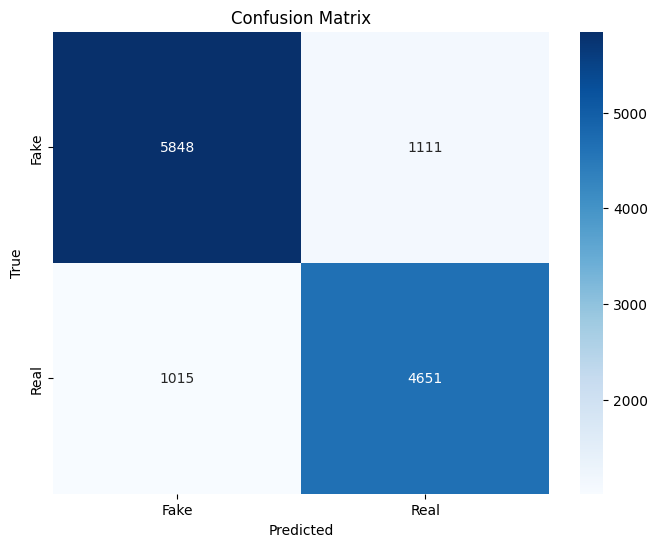

['saved_models/tfidf_vectorizer.pkl']

In [21]:
# Train Naive Bayes Classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_vectorized, y_train)

# Predict on test data
y_pred = nb_classifier.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

joblib.dump(nb_classifier, 'saved_models/naive_bayes_classifier.pkl')
joblib.dump(vectorizer, 'saved_models/tfidf_vectorizer.pkl')